In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120, facecolor="white")

BASE = Path("../data/processed/SKCM_GSE134388_aPD1_adata_base.h5ad")

# QC-filtered object in script 02, use that instead:
QC_IN = Path("../data/processed/SKCM_GSE134388_aPD1_qc.h5ad")

adata = sc.read_h5ad(QC_IN if QC_IN.exists() else BASE)

print(adata)
print("X type:", type(adata.X))


AnnData object with n_obs × n_vars = 3632 × 14705
    obs: 'UMAP_1', 'UMAP_2', 'Cluster', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Patient', 'Sample', 'Tissue'
X type: <class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
# Treat var index as gene symbol/name
adata.var_names_make_unique()

# Reset mt flag properly (human: MT-)
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

print("mt counts:")
print(adata.var["mt"].value_counts())

# If mt=True is still extremely low, print examples to confirm naming
mt_genes = adata.var_names[adata.var["mt"]].tolist()
print("Example mt genes:", mt_genes[:20])
print("Example non-mt genes:", adata.var_names[~adata.var["mt"]][:14].tolist())


mt counts:
mt
False    14692
True        13
Name: count, dtype: int64
Example mt genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']
Example non-mt genes: ['FO538757.2', 'AP006222.2', 'RP11-206L10.9', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'RP11-54O7.17', 'HES4', 'ISG15', 'AGRN', 'C1orf159', 'TNFRSF18']


In [ ]:
# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

qc_cols = ["total_counts", "n_genes_by_counts", "pct_counts_mt"]
print(adata.obs[qc_cols].describe())


       total_counts  n_genes_by_counts  pct_counts_mt
count   3632.000000        3632.000000    3632.000000
mean    1987.706787        1096.058370       1.975724
std      448.037140         533.034843       0.555794
min      757.283936         499.000000       0.000000
25%     1609.847992         680.000000       1.578019
50%     1930.823792         929.500000       1.911964
75%     2326.725525        1369.250000       2.321077
max     3496.391846        4420.000000       4.460252


In [ ]:
# Filter & Removing genes detected in very few cells
sc.pp.filter_genes(adata, min_cells=3)

# Store raw counts layer BEFORE normalization
adata.layers["counts"] = adata.X.copy()
print("After gene filter:", adata.shape)


After gene filter: (3632, 14705)


In [ ]:
# Normalize + log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Store log-normalized as default X; keep counts in layers["counts"]
print("Done normalize_total + log1p")


normalizing counts per cell
    finished (0:00:00)
Done normalize_total + log1p


In [ ]:
# Highly variable genes (HVG)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000
)

print("HVGs:", int(adata.var["highly_variable"].sum()))
adata.var[["highly_variable"]].value_counts()


extracting highly variable genes
HVGs: 2000


c:\Users\mmsid\Documents\github\My Project\Ishizuka_scRNAseq_Immunotherapy\.venv\Lib\site-packages\legacy_api_wrap\__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


highly_variable
False              12705
True                2000
Name: count, dtype: int64

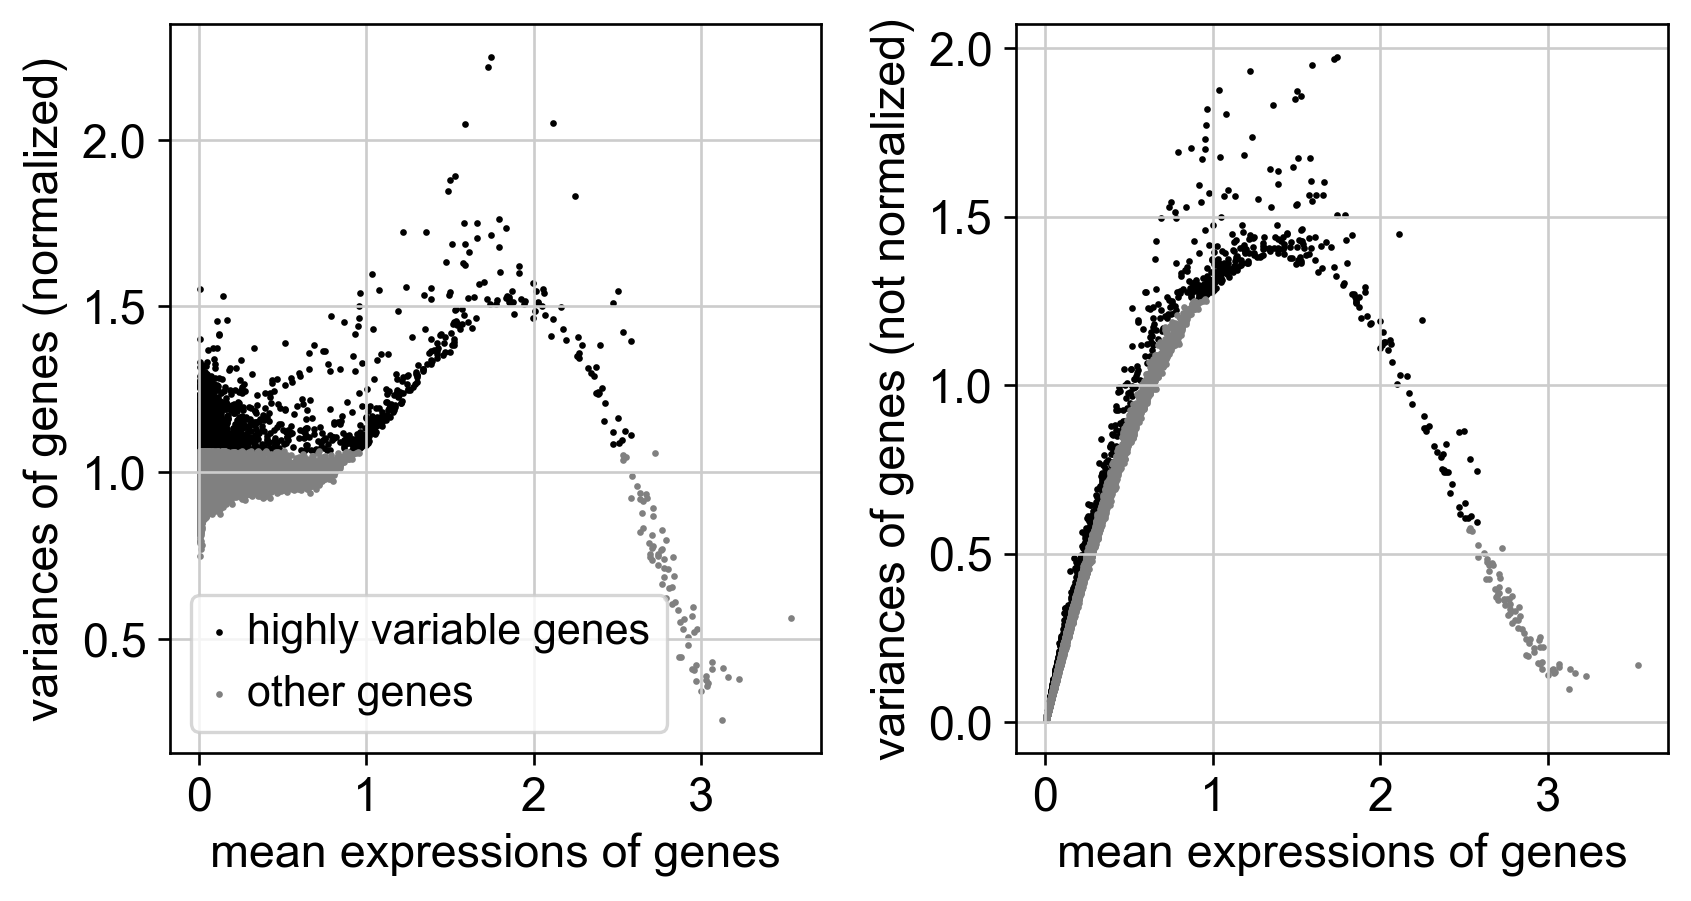

In [ ]:
# Plot the graph
sc.pl.highly_variable_genes(adata)


adata_hvg: (3632, 3000)
computing PCA
    with n_comps=50


C:\Program Files\Python311\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


    finished (0:00:04)


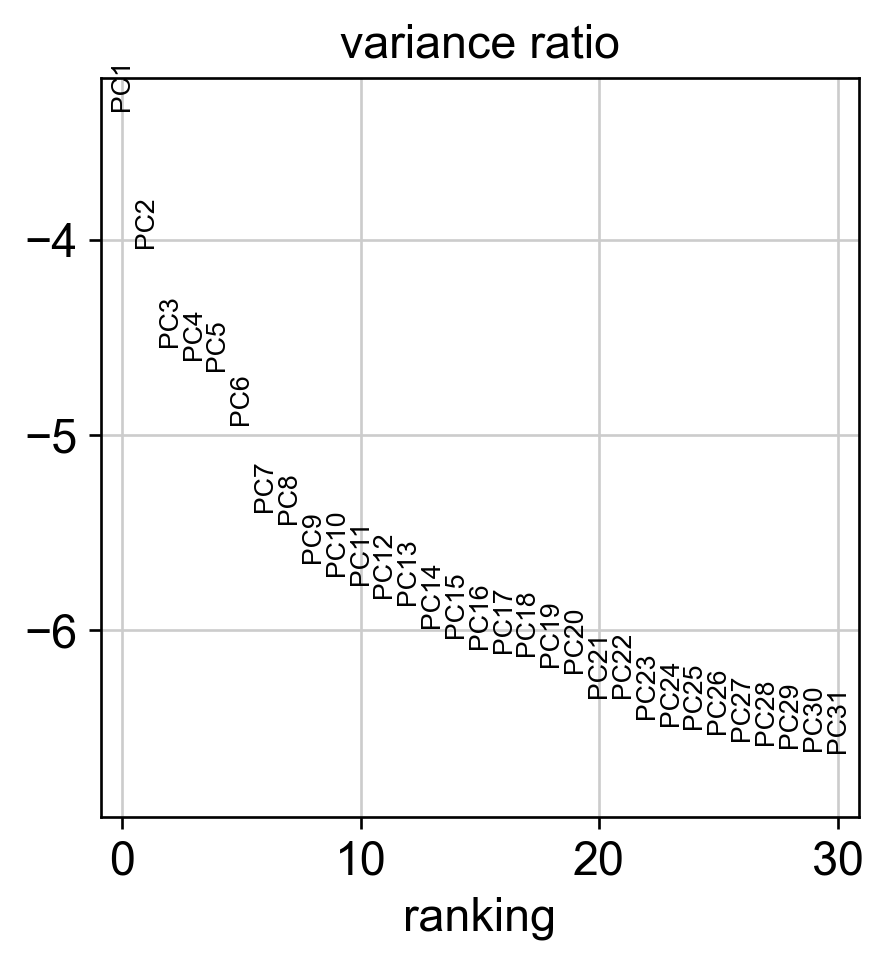

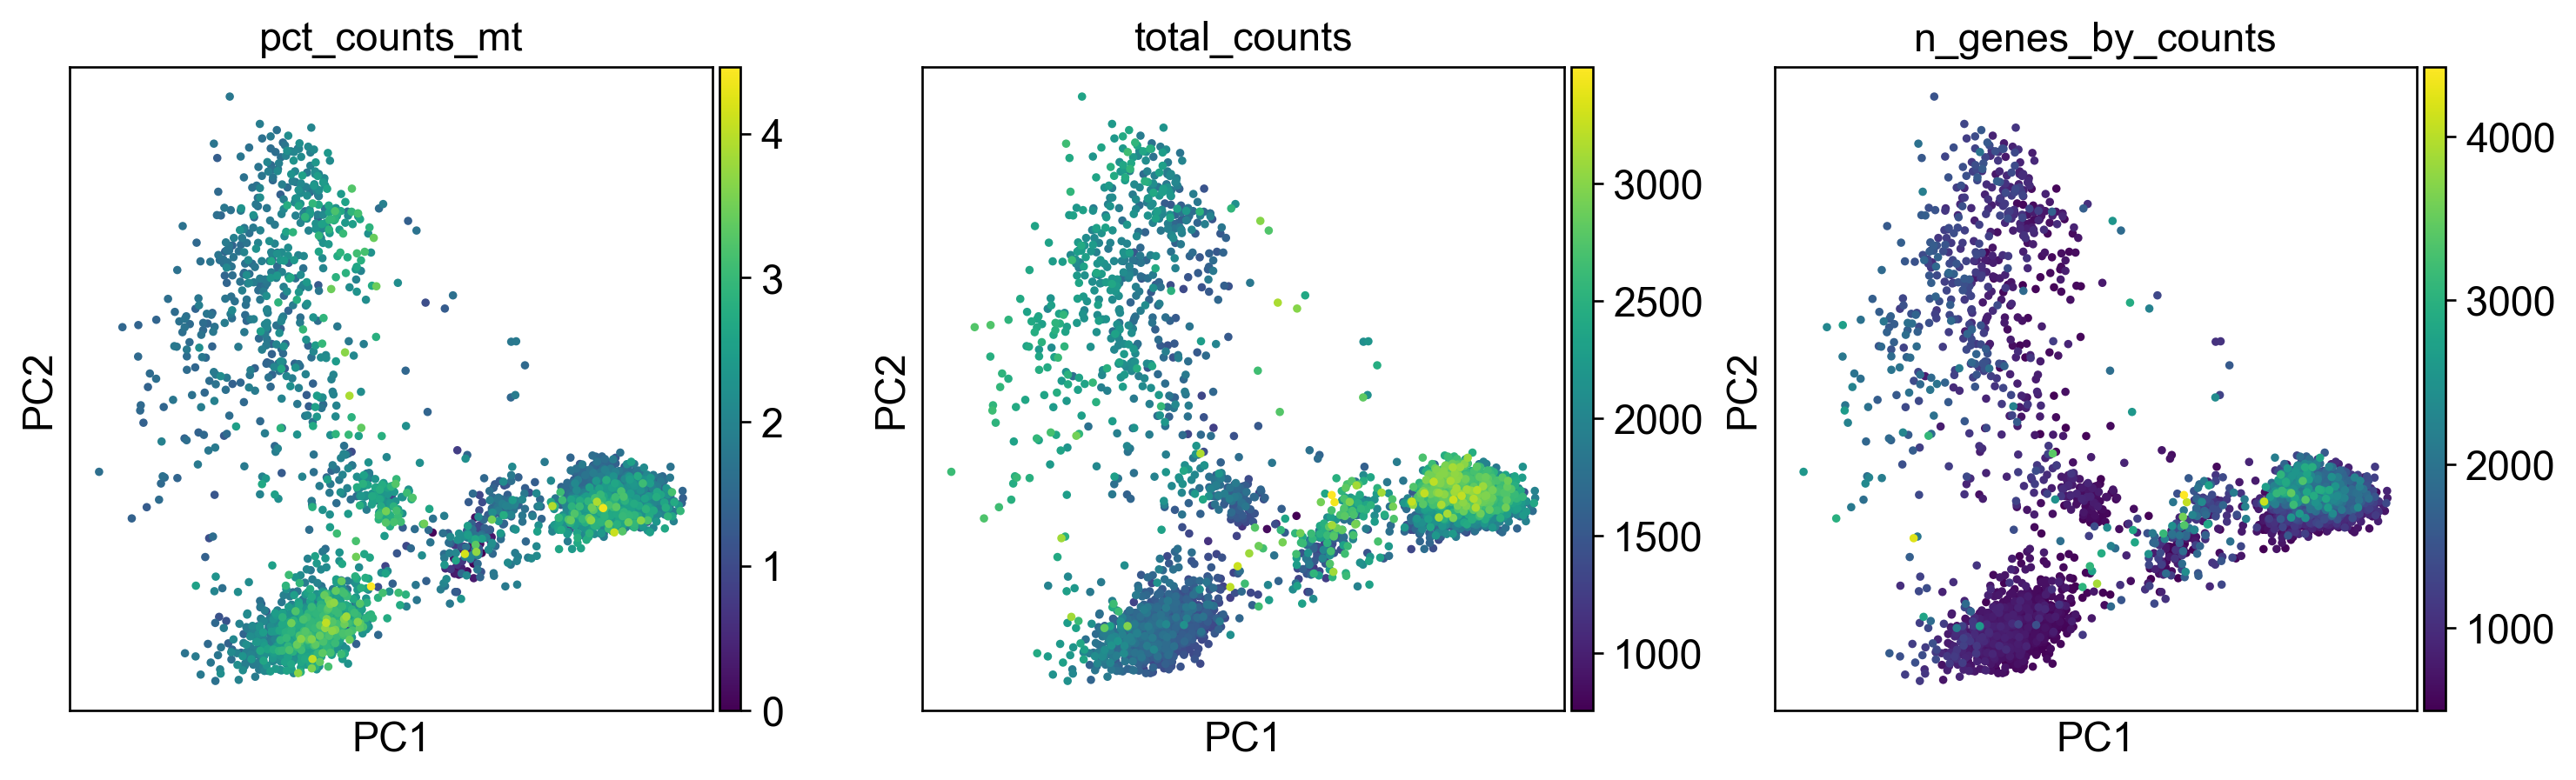

In [ ]:
# Computing PCA
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
print("adata_hvg:", adata_hvg.shape)

sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg, svd_solver="arpack")

sc.pl.pca_variance_ratio(adata_hvg, log=True)
sc.pl.pca(adata_hvg, color=["pct_counts_mt", "total_counts", "n_genes_by_counts"])


In [ ]:
# Save the Plot
import matplotlib.pyplot as plt
from pathlib import Path

Path("../results/pca").mkdir(parents=True, exist_ok=True)

sc.pl.pca(adata_hvg, color=["pct_counts_mt","total_counts","n_genes_by_counts"], show=False)
plt.savefig("../results/pca/pca_pc1_pc2_qc_metrics.png", dpi=200, bbox_inches="tight")
plt.close()

print("Saved: ../results/pca/pca_pc1_pc2_qc_metrics.png")

Saved: ../results/pca/pca_pc1_pc2_qc_metrics.png


In [ ]:
# Save the File
OUT = Path("../data/processed/SKCM_GSE134388_aPD1_norm_hvg_pca.h5ad")
OUT.parent.mkdir(parents=True, exist_ok=True)

adata_hvg.write_h5ad(OUT)
print("Saved:", OUT)


Saved: ..\data\processed\SKCM_GSE134388_aPD1_norm_hvg_pca.h5ad
